In [ ]:
import zipfile
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
!wget --no-check-certificate \
    "https://github.com/Syzst/vistique/archive/refs/heads/master.zip" \
    -O "/tmp/batik-vistique-split.zip"


zip_ref = zipfile.ZipFile('/tmp/batik-vistique-split.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

--2023-06-13 10:45:50--  https://github.com/Syzst/vistique/archive/refs/heads/master.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/Syzst/vistique/zip/refs/heads/master [following]
--2023-06-13 10:45:50--  https://codeload.github.com/Syzst/vistique/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 140.82.114.10
Connecting to codeload.github.com (codeload.github.com)|140.82.114.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘/tmp/batik-vistique-split.zip’

/tmp/batik-vistique     [           <=>      ]  55.54M  24.9MB/s    in 2.2s    

2023-06-13 10:45:53 (24.9 MB/s) - ‘/tmp/batik-vistique-split.zip’ saved [58236578]



In [ ]:
print('Test set Batik Ikat Celup' , len(os.listdir('/tmp/vistique-master/Testing/Batik Ikat Celup')))
print('Test set Batik Insang' , len(os.listdir('/tmp/vistique-master/Testing/Batik Insang')))
print('Test set Batik Kawung' , len(os.listdir('/tmp/vistique-master/Testing/Batik Kawung')))
print('Test set Batik Megamendung' , len(os.listdir('/tmp/vistique-master/Testing/Batik Megamendung')))
print('Test set Batik parang' , len(os.listdir('/tmp/vistique-master/Testing/Batik Parang')))
print('Train set Batik Ikat Celup' , len(os.listdir('/tmp/vistique-master/Training/Batik Ikat Celup')))
print('Train set Batik Insang' , len(os.listdir('/tmp/vistique-master/Training/Batik Insang')))
print('Train set Batik Kawung' , len(os.listdir('/tmp/vistique-master/Training/Batik Kawung')))
print('Train set Batik Megamendung' , len(os.listdir('/tmp/vistique-master/Training/Batik Megamendung')))
print('Train set Batik parang' , len(os.listdir('/tmp/vistique-master/Training/Batik Parang')))


#Expected Results
#Test set Batik Ikat Celup 90
#Test set Batik Insang 90
#Test set Batik Kawung 90
#Test set Batik Megamendung 90
#Test set Batik parang 90
#Train set Batik Ikat Celup 210
#Train set Batik Insang 210
#Train set Batik Kawung 210
#Train set Batik Megamendung 210
#Train set Batik parang 210

Test set Batik Ikat Celup 90
Test set Batik Insang 90
Test set Batik Kawung 90
Test set Batik Megamendung 90
Test set Batik parang 90
Train set Batik Ikat Celup 210
Train set Batik Insang 210
Train set Batik Kawung 210
Train set Batik Megamendung 210
Train set Batik parang 210


In [ ]:
train_dir = "/tmp/vistique-master/Training"
test_dir = "/tmp/vistique-master/Testing"

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    rotation_range=90,
    fill_mode='reflect',
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

testing_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(224,224),
    class_mode='categorical',
    batch_size=20,
    color_mode='rgb'
)

testing_generator = testing_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(224,224),
    class_mode='categorical',
    batch_size=20,
    color_mode='rgb'
)

motives_dict = train_generator.class_indices
print(motives_dict)

Found 1050 images belonging to 5 classes.
Found 450 images belonging to 5 classes.
{'Batik Ikat Celup': 0, 'Batik Insang': 1, 'Batik Kawung': 2, 'Batik Megamendung': 3, 'Batik Parang': 4}


In [ ]:
from tensorflow.keras.applications import MobileNetV2

base_model = MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
    alpha=0.5,
    pooling='avg'
)

base_model.trainable = False

3201480/3201480 [==============================] - 0s 0us/step


In [ ]:
import tensorflow as tf

def scheduler(epoch, lr):
  if epoch <= 10:
    return lr
  elif 10 < epoch <= 20:
    return lr * tf.math.exp(-0.1)
  else:
    return lr * tf.math.exp(-0.2)

lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
EPOCHS = 10
LEARNING_RATE = 1e-4
TRAIN_STEP = 700//20
TEST_STEP = 200//20

In [ ]:
from tensorflow.keras.backend import clear_session
from tensorflow.keras import Sequential, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

clear_session()

model = Sequential([
    base_model,
    Dense(100, activation='relu',
          kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)
    ),
    Dropout(0.3),
    Dense(5, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

model.summary()

history = model.fit(
    train_generator,
    validation_data=testing_generator,
    steps_per_epoch=TRAIN_STEP,
    validation_steps=TEST_STEP,
    shuffle=True,
    epochs=EPOCHS,
    callbacks=[lr_callback]
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_0.50_224 (Funct  (None, 1280)             706224    
 ional)                                                          
                                                                 
 dense (Dense)               (None, 100)               128100    
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 505       
                                                                 
Total params: 834,829
Trainable params: 128,605
Non-trainable params: 706,224
_________________________________________________________________
Epoch 1/10
35/35 [==============================] - 23s 516ms/step - loss: 1.9362 - accuracy: 0.2768 - val_los

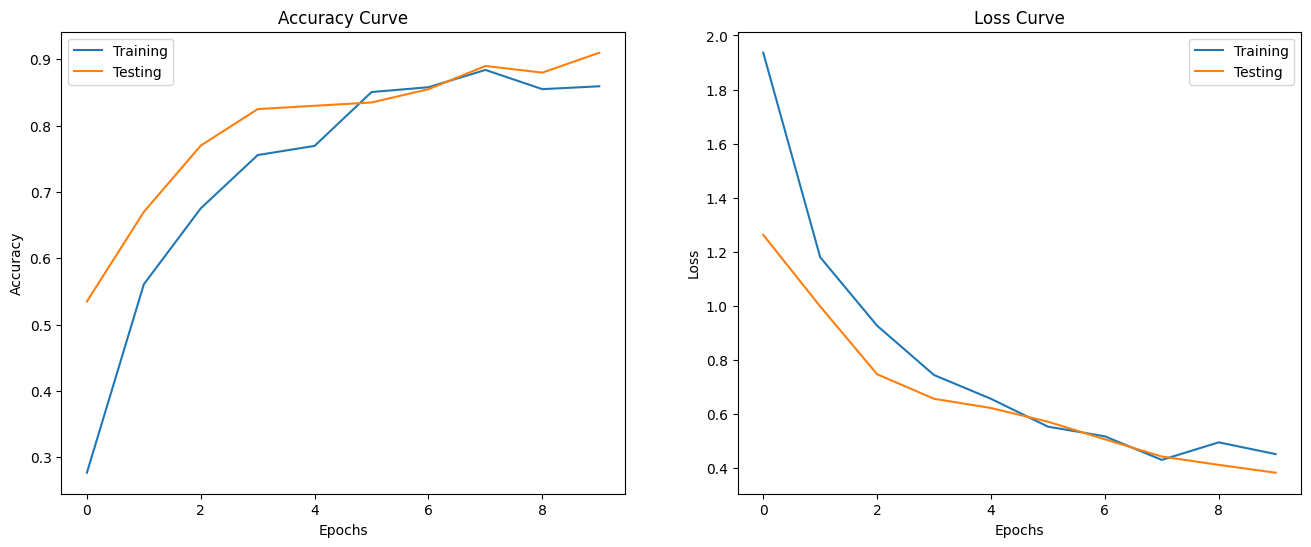

In [ ]:
import matplotlib.pyplot as plt

train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)
plt.title('Accuracy Curve')
plt.plot(train_acc, label='Training')
plt.plot(val_acc, label='Testing')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.title('Loss Curve')
plt.plot(train_loss, label='Training')
plt.plot(val_loss, label='Testing')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np

test_dir = '/tmp/vistique-master/Testing'

for motive in motives_dict.keys():
    images_list = os.listdir(os.path.join(test_dir, motive))
    # plt.figure(figsize=(16, 20))

    correct_count = 0

    for idx, image in enumerate(images_list):
        img_path = f'/tmp/vistique-master/Testing/{motive}/{image}'
        img = load_img(img_path, target_size=(224, 224))

        img_array = img_to_array(img) / 255.0
        img_array = tf.expand_dims(img_array, 0)

        motives_list = list(motives_dict.keys())
        prediction = model(img_array)
        pred_idx = np.argmax(prediction)
        pred_motive = motives_list[pred_idx]
        pred_confidence = prediction[0][pred_idx] * 100

        if pred_motive == motive:
            correct_count += 1

    print(f'{motive} Predictions --> {correct_count}/90 correct')
# plt.show()


Batik Ikat Celup Predictions --> 89/90 correct
Batik Insang Predictions --> 84/90 correct
Batik Kawung Predictions --> 81/90 correct
Batik Megamendung Predictions --> 70/90 correct
Batik Parang Predictions --> 83/90 correct


In [ ]:
from tensorflow.keras.models import load_model

# Save the model
model.save('/content/drive/MyDrive/Batik Datasets Saved Model/Batik-Datasets.h5')

In [ ]:
# convert keras model to tflite
def get_file_size(file_path):
    size = os.path.getsize(file_path)
    return size

def convert_bytes(size, unit=None):
    if unit == "KB":
        return print('File size: ' + str(round(size / 1024, 3)) + ' Kilobytes')
    elif unit == "MB":
        return print('File size: ' + str(round(size / (1024 * 1024), 3)) + ' Megabytes')
    else:
        return print('File size: ' + str(size) + ' bytes')

In [ ]:
from keras.models import load_model
model = load_model("/content/drive/MyDrive/Batik Datasets Saved Model/Batik-Datasets.h5")

TF_LITE_MODEL_FILE_NAME = "tflite_model.tflite"
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = tf_lite_converter.convert()
tflite_model_name = TF_LITE_MODEL_FILE_NAME
open(tflite_model_name, "wb").write(tflite_model)
convert_bytes(get_file_size(TF_LITE_MODEL_FILE_NAME), "KB")

# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
# or using another method

# Save the model.
with open('/content/drive/MyDrive/Batik Datasets Saved Model/Batik-Datasets.tflite', 'wb') as f:
  f.write(tflite_model)

File size: 3191.074 Kilobytes


In [ ]:
interpreter = tf.lite.Interpreter(model_path = TF_LITE_MODEL_FILE_NAME)
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [  1 224 224   3]
Input Type: <class 'numpy.float32'>
Output Shape: [1 5]
Output Type: <class 'numpy.float32'>
